<a href="https://colab.research.google.com/github/jmq19950824/Machine-Learning-with-Python/blob/master/Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
%matplotlib inline

GPU Environment

In [3]:
is_cuda=torch.cuda.is_available()
is_cuda

True

Original Data

In [0]:
data_transform=transforms.Compose([transforms.Resize((299,299)),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

In [0]:
train_dataset=ImageFolder('/content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/minitrain',transform=data_transform)
valid_dataset=ImageFolder('/content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/minivalid',transform=data_transform)

train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=False,num_workers=8)
valid_dataloader=DataLoader(valid_dataset,batch_size=32,shuffle=False,num_workers=8)

In [6]:
print(train_dataset)
print(valid_dataset)

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/minitrain
    StandardTransform
Transform: Compose(
               Resize(size=(299, 299), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/minivalid
    StandardTransform
Transform: Compose(
               Resize(size=(299, 299), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Create Inception Model

In [7]:
model_inception=inception_v3(pretrained=True)
model_inception.aux_logits=False

if is_cuda:
  model_inception=model_inception.cuda()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


Extracting Convolutional Features

In [0]:
class LayerActivations():
  def __init__(self,model):
    self.features=[]
    self.hook=model.register_forward_hook(self.hook_fn)

  def hook_fn(self,module,input,output):
    self.features.extend(output.view(output.size(0),-1).cpu().data)

  def remove(self):
    self.hook.remove()

In [0]:
train_features=LayerActivations(model_inception.Mixed_7c)
train_labels=[]

for data,label in train_dataloader:
  _=model_inception(Variable(data.cuda()))
  train_labels.extend(label)

train_features.remove()

In [0]:
valid_features=LayerActivations(model_inception.Mixed_7c)
valid_labels=[]

for data,label in valid_dataloader:
  _=model_inception(Variable(data.cuda()))
  valid_labels.extend(label)

valid_features.remove()

Customize the Dataset

In [0]:
class FeaturesDataset(Dataset):
  def __init__(self,featurelist,labellist):
    self.featurelist=featurelist
    self.labellist=labellist

  def __getitem__(self,index):
    return(self.featurelist[index],self.labellist[index])

  def __len__(self):
    return len(self.labellist)

Creating Train and Validation Feature Dataset(DataLoader)

In [0]:
train_feature_dataset=FeaturesDataset(train_features.features,train_labels)
valid_feature_dataset=FeaturesDataset(valid_features.features,valid_labels)

train_feature_loader=DataLoader(train_feature_dataset,batch_size=64,shuffle=True)
valid_feature_loader=DataLoader(valid_feature_dataset,batch_size=64)

A Fully Connected Network

In [0]:
class FullyConnectedModel(nn.Module):
  def __init__(self,input_size,output_size,training=True):
    super().__init__()
    self.fc=nn.Linear(input_size,output_size)

  def forward(self,input):
    output=F.dropout(input,training=self.training,p=0.5)
    output=self.fc(output)
    return output

In [0]:
fc_in_size=131072
classes=2

fc=FullyConnectedModel(fc_in_size,classes)

if is_cuda:
  fc=fc.cuda()

Optimizer

In [0]:
optimizer=optim.Adam(fc.parameters(),lr=0.01)

Fit the Model

In [0]:
def fit(model,data_loader,phase='training',volatile=False):

  running_loss=0.0
  running_correct=0
  if phase=='training':
    model.train()
  if phase=='validation':
    model.eval()
    volatile=True

  for batch_idx,(data,target) in enumerate(data_loader):
    if is_cuda:
      data,target=data.cuda(),target.cuda()
    
    data,target=Variable(data,volatile),Variable(target)

    if phase=='training':
      optimizer.zero_grad()
    
    output=model(data)
    loss=F.cross_entropy(output,target)
    running_loss+=F.cross_entropy(output,target,size_average=False).data.item()

    preds=output.data.max(dim=1,keepdim=True)[1]
    running_correct+=preds.eq(target.data.view_as(preds)).cpu().sum()

    if phase=='training':
      loss.backward()
      optimizer.step()

  loss=running_loss/len(data_loader.dataset)
  accuracy=100.*running_correct/len(data_loader.dataset)

  print(f'{phase} loss is {loss} and accuracy is {accuracy}')

  return loss,accuracy

In [57]:
train_loss,train_acc=[],[]
valid_loss,valid_acc=[],[]

for epoch in range(1,20):
  train_epoch_loss,train_epoch_acc=fit(fc,train_feature_loader,phase='training')
  valid_epoch_loss,valid_epoch_acc=fit(fc,valid_feature_loader,phase='validation')

  train_loss.append(train_epoch_loss)
  train_acc.append(train_epoch_acc)

  valid_loss.append(valid_epoch_loss)
  valid_acc.append(valid_epoch_acc)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 70.94008355140686 and accuracy is 62.70000076293945
validation loss is 14.31446083831787 and accuracy is 75.30000305175781
training loss is 4.071392342209816 and accuracy is 90.75
validation loss is 4.457132048070431 and accuracy is 87.4000015258789
training loss is 0.7844171045571565 and accuracy is 97.4000015258789
validation loss is 6.29143728017807 and accuracy is 86.9000015258789
training loss is 0.5583581600189209 and accuracy is 98.05000305175781
validation loss is 2.486764986038208 and accuracy is 92.69999694824219
training loss is 0.14280312153697014 and accuracy is 99.0
validation loss is 2.206189339876175 and accuracy is 93.69999694824219
training loss is 0.1506187287569046 and accuracy is 99.1500015258789
validation loss is 4.360122102737427 and accuracy is 89.80000305175781
training loss is 0.18769294348359108 and accuracy is 99.0999984741211
validation loss is 3.4204036502838133 and accuracy is 92.0999984741211
training loss is 0.18930424973368645 and acc

In [0]:
matrix_2_2=valid_acc

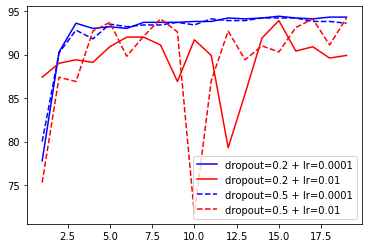

In [59]:
import matplotlib.pyplot as plt
plt.plot(range(1,20),matrix_1_1,'b',label='dropout=0.2 + lr=0.0001')
plt.plot(range(1,20),matrix_1_2,'r',label='dropout=0.2 + lr=0.01')

plt.plot(range(1,20),matrix_2_1,'--b',label='dropout=0.5 + lr=0.0001')
plt.plot(range(1,20),matrix_2_2,'--r',label='dropout=0.5 + lr=0.01')

plt.legend()